In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)

from libs.lib import *

d:\ICIT


In [2]:
wandb.init(project="ads_nckh_fraud_detection")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dinhtanloc (nckh_ueh). Use `wandb login --relogin` to force relogin


In [3]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [4]:
exps_dir = "../../../exps"
# exps_dir = sys.argv[3]

if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [5]:
dict_data=[]
y_list = []
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    
    # Khởi tạo một trình chuyển đổi OneHotEncoder
    encoder = OneHotEncoder(sparse=False)
    
    # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
    labels_reshaped = labels.reshape(-1, 1)
    
    # Fit trình chuyển đổi vào dữ liệu
    encoder.fit(labels_reshaped)
    
    # Chuyển đổi labels sang dạng one-hot encoding
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels
for scaler in ['Standard_Label','MinMax_Label']:
    for type in ['basic','class_dict_weight','Oversampling','SMOTE','Undersampling']:
        x_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_train.xlsx')
        y_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_train.xlsx')
        x_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_test.xlsx')
        y_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_test.xlsx')
        y_list.append(y_test)
        y_train=oneHot(y_train)
        y_test=oneHot(y_test)
        print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
        dict_data.append((x_train,y_train,x_test,y_test))

class_weights_dict=dict(np.load(f'{exps_dir}/Standard_Label/class_dict_weight/feature/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict
print(len(dict_data))

(656, 42) (656, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(1001, 42) (1001, 2) (324, 42) (324, 2)
(1002, 42) (1002, 2) (324, 42) (324, 2)
(355, 42) (355, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(1001, 42) (1001, 2) (324, 42) (324, 2)
(1002, 42) (1002, 2) (324, 42) (324, 2)
(355, 42) (355, 2) (324, 42) (324, 2)
10


In [6]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{exps_dir}/feature1/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0, 1: 1.0}

In [7]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    # Khởi tạo một trình chuyển đổi OneHotEncoder
    encoder = OneHotEncoder(sparse=False)
    
    # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
    labels_reshaped = labels.reshape(-1, 1)
    
    # Fit trình chuyển đổi vào dữ liệu
    encoder.fit(labels_reshaped)
    
    # Chuyển đổi labels sang dạng one-hot encoding
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)

In [8]:
x_test.shape

(330, 42)

In [9]:
x_train.shape

(1022, 42)

#### * Xây dựng model:

In [10]:
#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, num_classes=2)
#y_test = to_categorical(y_test, num_classes=2)
#y_train

In [11]:
from sklearn.metrics import f1_score
import tensorflow as tf
def f1_loss(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(y_pred, tf.float32))
    possible_positives = tf.reduce_sum(tf.cast(y_true, tf.float32))
    
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return 1 - f1

In [12]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss


In [13]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [15]:
from keras import backend as K

def f1_score(y_true, y_pred):
    """
    F1 score metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

In [16]:
from tensorflow.keras.optimizers.legacy import Adam
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten
from keras.models import Model
from keras.layers import Input
import tensorflow as tf
input_shape =(42,1)
x_input = Input(shape=input_shape)
dense_units = 1024
learning_rate = 0.0001
kernel_size =3
filter_size=128


# Block 1
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv1')(x_input)
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block1_pool')(x)

# Block 2
x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv1')(x)
x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block2_pool')(x)

# Block 3
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv1')(x)
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv2')(x)
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block3_pool')(x)

# Block 4
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv1')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv2')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block4_pool')(x)

# Block 5
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv1')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv2')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block5_pool')(x)

# x = Flatten(name='flatten')(x)
# x = Dense(dense_units, activation='relu', name='fc1')(x)
# x = Dense(dense_units, activation='relu', name='fc2')(x)
# x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

x = GlobalAveragePooling1D()(x)
# x = GlobalMaxPooling1D()(x)
x = Dense(2, activation='softmax', name='predictions')(x)  # Sigmoid for binary classification

# Create model.
model = Model(x_input, x, name='vgg16')
# model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',f1_score])
model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=['accuracy',f1_score])
early_stopping = EarlyStopping(monitor='val_accuracy',
    # min_delta=0.00005,
    patience=60,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.95,
    patience=15,
    min_lr=0.000001,
    verbose=1,
)
checkpointer = ModelCheckpoint(filepath = "Emotion_weights.hdf5",monitor='val_accuracy', verbose = 1, save_best_only=True)


In [17]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42, 1)]           0         
                                                                 
 block1_conv1 (Conv1D)       (None, 42, 128)           512       
                                                                 
 block1_conv2 (Conv1D)       (None, 42, 128)           49280     
                                                                 
 block1_pool (MaxPooling1D)  (None, 21, 128)           0         
                                                                 
 block2_conv1 (Conv1D)       (None, 21, 256)           98560     
                                                                 
 block2_conv2 (Conv1D)       (None, 21, 256)           196864    
                                                                 
 block2_pool (MaxPooling1D)  (None, 10, 256)           0     

In [18]:
#Set data order
data_order = 8

In [19]:
model.fit(x=dict_data[data_order][0],y=dict_data[data_order][1],
          validation_data=(dict_data[data_order][2],dict_data[data_order][3]),
          batch_size=64,epochs= 10000, callbacks=[wandb.keras.WandbCallback(),early_stopping,lr_scheduler,checkpointer])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10000
16/16 [==============================] - ETA: 0s - loss: 0.4964 - accuracy: 0.5000 - f1_score: 0.4985INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets
wandb: Adding directory to artifact (d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best)... Done. 0.4s



Epoch 1: val_accuracy improved from -inf to 0.73765, saving model to Emotion_weights.hdf5
16/16 [==============================] - 19s 1s/step - loss: 0.4964 - accuracy: 0.5000 - f1_score: 0.4985 - val_loss: 0.3343 - val_accuracy: 0.7377 - val_f1_score: 0.7396 - lr: 1.0000e-04
Epoch 2/10000
16/16 [==============================] - ETA: 0s - loss: 0.4803 - accuracy: 0.5030 - f1_score: 0.5024
Epoch 2: val_accuracy did not improve from 0.73765
16/16 [==============================] - 14s 873ms/step - loss: 0.4803 - accuracy: 0.5030 - f1_score: 0.5024 - val_loss: 0.4852 - val_accuracy: 0.5463 - val_f1_score: 0.5000 - lr: 1.0000e-04
Epoch 3/10000
16/16 [==============================] - ETA: 0s - loss: 0.4160 - accuracy: 0.6198 - f1_score: 0.6233
Epoch 3: val_accuracy did not improve from 0.73765
16/16 [==============================] - 14s 889ms/step - loss: 0.4160 - accuracy: 0.6198 - f1_score: 0.6233 - val_loss: 0.3806 - val_accuracy: 0.6204 - val_f1_score: 0.6016 - lr: 1.0000e-04
Epoch

INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets
wandb: Adding directory to artifact (d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best)... Done. 0.5s



Epoch 4: val_accuracy did not improve from 0.73765
16/16 [==============================] - 17s 1s/step - loss: 0.2690 - accuracy: 0.7415 - f1_score: 0.7409 - val_loss: 0.3140 - val_accuracy: 0.6914 - val_f1_score: 0.7396 - lr: 1.0000e-04
Epoch 5/10000
16/16 [==============================] - ETA: 0s - loss: 0.2380 - accuracy: 0.7615 - f1_score: 0.7615
Epoch 5: val_accuracy did not improve from 0.73765
16/16 [==============================] - 14s 852ms/step - loss: 0.2380 - accuracy: 0.7615 - f1_score: 0.7615 - val_loss: 0.3875 - val_accuracy: 0.6111 - val_f1_score: 0.6328 - lr: 1.0000e-04
Epoch 6/10000
16/16 [==============================] - ETA: 0s - loss: 0.2183 - accuracy: 0.7834 - f1_score: 0.7835
Epoch 6: val_accuracy did not improve from 0.73765
16/16 [==============================] - 13s 831ms/step - loss: 0.2183 - accuracy: 0.7834 - f1_score: 0.7835 - val_loss: 0.5653 - val_accuracy: 0.4383 - val_f1_score: 0.4089 - lr: 1.0000e-04
Epoch 7/10000
16/16 [=======================

INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets
wandb: Adding directory to artifact (d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best)... Done. 0.5s



Epoch 7: val_accuracy did not improve from 0.73765
16/16 [==============================] - 16s 1s/step - loss: 0.2892 - accuracy: 0.7116 - f1_score: 0.7142 - val_loss: 0.3117 - val_accuracy: 0.6883 - val_f1_score: 0.6979 - lr: 1.0000e-04
Epoch 8/10000
16/16 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.7884 - f1_score: 0.7884INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets
wandb: Adding directory to artifact (d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best)... Done. 0.5s



Epoch 8: val_accuracy did not improve from 0.73765
16/16 [==============================] - 17s 1s/step - loss: 0.2097 - accuracy: 0.7884 - f1_score: 0.7884 - val_loss: 0.3108 - val_accuracy: 0.6944 - val_f1_score: 0.7422 - lr: 1.0000e-04
Epoch 9/10000
16/16 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.7545 - f1_score: 0.7541INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets
wandb: Adding directory to artifact (d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best)... Done. 0.4s



Epoch 9: val_accuracy did not improve from 0.73765
16/16 [==============================] - 17s 1s/step - loss: 0.2453 - accuracy: 0.7545 - f1_score: 0.7541 - val_loss: 0.2854 - val_accuracy: 0.7130 - val_f1_score: 0.7187 - lr: 1.0000e-04
Epoch 10/10000
16/16 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.8094 - f1_score: 0.8114
Epoch 10: val_accuracy did not improve from 0.73765
16/16 [==============================] - 18s 1s/step - loss: 0.1929 - accuracy: 0.8094 - f1_score: 0.8114 - val_loss: 0.3066 - val_accuracy: 0.6944 - val_f1_score: 0.7422 - lr: 1.0000e-04
Epoch 11/10000
16/16 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.8194 - f1_score: 0.8176
Epoch 11: val_accuracy did not improve from 0.73765
16/16 [==============================] - 15s 904ms/step - loss: 0.1786 - accuracy: 0.8194 - f1_score: 0.8176 - val_loss: 0.2981 - val_accuracy: 0.7006 - val_f1_score: 0.7083 - lr: 1.0000e-04
Epoch 12/10000
16/16 [=====================

INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets
wandb: Adding directory to artifact (d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best)... Done. 0.4s



Epoch 14: val_accuracy did not improve from 0.73765
16/16 [==============================] - 17s 1s/step - loss: 0.3370 - accuracy: 0.6647 - f1_score: 0.6668 - val_loss: 0.2731 - val_accuracy: 0.7253 - val_f1_score: 0.7292 - lr: 1.0000e-04
Epoch 15/10000
16/16 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.7994 - f1_score: 0.8001INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets
wandb: Adding directory to artifact (d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best)... Done. 0.6s



Epoch 15: val_accuracy improved from 0.73765 to 0.74074, saving model to Emotion_weights.hdf5
16/16 [==============================] - 19s 1s/step - loss: 0.2010 - accuracy: 0.7994 - f1_score: 0.8001 - val_loss: 0.2610 - val_accuracy: 0.7407 - val_f1_score: 0.7812 - lr: 1.0000e-04
Epoch 16/10000
16/16 [==============================] - ETA: 0s - loss: 0.1968 - accuracy: 0.8044 - f1_score: 0.8035
Epoch 16: val_accuracy did not improve from 0.74074
16/16 [==============================] - 15s 938ms/step - loss: 0.1968 - accuracy: 0.8044 - f1_score: 0.8035 - val_loss: 0.3710 - val_accuracy: 0.6265 - val_f1_score: 0.6849 - lr: 1.0000e-04
Epoch 17/10000
16/16 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.7794 - f1_score: 0.7796
Epoch 17: val_accuracy did not improve from 0.74074
16/16 [==============================] - 16s 987ms/step - loss: 0.2210 - accuracy: 0.7794 - f1_score: 0.7796 - val_loss: 0.3049 - val_accuracy: 0.6944 - val_f1_score: 0.7031 - lr: 1.0000e-

INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets
wandb: Adding directory to artifact (d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best)... Done. 0.4s



Epoch 23: val_accuracy improved from 0.74074 to 0.75000, saving model to Emotion_weights.hdf5
16/16 [==============================] - 18s 1s/step - loss: 0.1995 - accuracy: 0.8024 - f1_score: 0.8020 - val_loss: 0.2542 - val_accuracy: 0.7500 - val_f1_score: 0.7891 - lr: 1.0000e-04
Epoch 24/10000
16/16 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.7166 - f1_score: 0.7175
Epoch 24: val_accuracy did not improve from 0.75000
16/16 [==============================] - 15s 938ms/step - loss: 0.2842 - accuracy: 0.7166 - f1_score: 0.7175 - val_loss: 0.4514 - val_accuracy: 0.5494 - val_f1_score: 0.5026 - lr: 1.0000e-04
Epoch 25/10000
16/16 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.7874 - f1_score: 0.7848
Epoch 25: val_accuracy did not improve from 0.75000
16/16 [==============================] - 15s 934ms/step - loss: 0.2120 - accuracy: 0.7874 - f1_score: 0.7848 - val_loss: 0.2798 - val_accuracy: 0.7222 - val_f1_score: 0.7266 - lr: 1.0000e-

INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets
wandb: Adding directory to artifact (d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best)... Done. 0.4s



Epoch 26: val_accuracy did not improve from 0.75000
16/16 [==============================] - 19s 1s/step - loss: 0.2051 - accuracy: 0.7944 - f1_score: 0.7952 - val_loss: 0.2516 - val_accuracy: 0.7500 - val_f1_score: 0.7109 - lr: 1.0000e-04
Epoch 27/10000
16/16 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.7984 - f1_score: 0.7981INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets
wandb: Adding directory to artifact (d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best)... Done. 0.5s



Epoch 27: val_accuracy improved from 0.75000 to 0.75926, saving model to Emotion_weights.hdf5
16/16 [==============================] - 20s 1s/step - loss: 0.2017 - accuracy: 0.7984 - f1_score: 0.7981 - val_loss: 0.2420 - val_accuracy: 0.7593 - val_f1_score: 0.7578 - lr: 1.0000e-04
Epoch 28/10000
16/16 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.7774 - f1_score: 0.7781
Epoch 28: val_accuracy did not improve from 0.75926
16/16 [==============================] - 16s 973ms/step - loss: 0.2230 - accuracy: 0.7774 - f1_score: 0.7781 - val_loss: 0.3256 - val_accuracy: 0.6759 - val_f1_score: 0.6484 - lr: 1.0000e-04
Epoch 29/10000
16/16 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.8244 - f1_score: 0.8230
Epoch 29: val_accuracy did not improve from 0.75926
16/16 [==============================] - 15s 955ms/step - loss: 0.1758 - accuracy: 0.8244 - f1_score: 0.8230 - val_loss: 0.2495 - val_accuracy: 0.7500 - val_f1_score: 0.7891 - lr: 1.0000e-

INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets
wandb: Adding directory to artifact (d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best)... Done. 0.4s



Epoch 34: val_accuracy improved from 0.75926 to 0.76543, saving model to Emotion_weights.hdf5
16/16 [==============================] - 16s 1s/step - loss: 0.2066 - accuracy: 0.7934 - f1_score: 0.7932 - val_loss: 0.2356 - val_accuracy: 0.7654 - val_f1_score: 0.7630 - lr: 1.0000e-04
Epoch 35/10000
16/16 [==============================] - ETA: 0s - loss: 0.2211 - accuracy: 0.7784 - f1_score: 0.7771
Epoch 35: val_accuracy did not improve from 0.76543
16/16 [==============================] - 13s 821ms/step - loss: 0.2211 - accuracy: 0.7784 - f1_score: 0.7771 - val_loss: 0.3930 - val_accuracy: 0.6019 - val_f1_score: 0.5859 - lr: 1.0000e-04
Epoch 36/10000
16/16 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.7665 - f1_score: 0.7674
Epoch 36: val_accuracy did not improve from 0.76543
16/16 [==============================] - 14s 854ms/step - loss: 0.2342 - accuracy: 0.7665 - f1_score: 0.7674 - val_loss: 0.3536 - val_accuracy: 0.6481 - val_f1_score: 0.6641 - lr: 1.0000e-

INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets
wandb: Adding directory to artifact (d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best)... Done. 0.6s



Epoch 45: val_accuracy did not improve from 0.76543
16/16 [==============================] - 16s 1s/step - loss: 0.1797 - accuracy: 0.8194 - f1_score: 0.8191 - val_loss: 0.2347 - val_accuracy: 0.7654 - val_f1_score: 0.7630 - lr: 1.0000e-04
Epoch 46/10000
16/16 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.8273 - f1_score: 0.8280
Epoch 46: val_accuracy did not improve from 0.76543
16/16 [==============================] - 13s 818ms/step - loss: 0.1739 - accuracy: 0.8273 - f1_score: 0.8280 - val_loss: 0.2573 - val_accuracy: 0.7438 - val_f1_score: 0.7839 - lr: 1.0000e-04
Epoch 47/10000
16/16 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.8253 - f1_score: 0.8240
Epoch 47: val_accuracy did not improve from 0.76543
16/16 [==============================] - 13s 843ms/step - loss: 0.1742 - accuracy: 0.8253 - f1_score: 0.8240 - val_loss: 0.2478 - val_accuracy: 0.7531 - val_f1_score: 0.7917 - lr: 1.0000e-04
Epoch 48/10000
16/16 [=================

INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets
wandb: Adding directory to artifact (d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best)... Done. 0.6s



Epoch 72: val_accuracy improved from 0.76543 to 0.77160, saving model to Emotion_weights.hdf5
16/16 [==============================] - 19s 1s/step - loss: 0.1676 - accuracy: 0.8323 - f1_score: 0.8313 - val_loss: 0.2280 - val_accuracy: 0.7716 - val_f1_score: 0.7292 - lr: 9.0250e-05
Epoch 73/10000
16/16 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.8124 - f1_score: 0.8138
Epoch 73: val_accuracy did not improve from 0.77160
16/16 [==============================] - 16s 976ms/step - loss: 0.1871 - accuracy: 0.8124 - f1_score: 0.8138 - val_loss: 0.2888 - val_accuracy: 0.7130 - val_f1_score: 0.6797 - lr: 9.0250e-05
Epoch 74/10000
16/16 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.8114 - f1_score: 0.8108
Epoch 74: val_accuracy did not improve from 0.77160
16/16 [==============================] - 16s 983ms/step - loss: 0.1897 - accuracy: 0.8114 - f1_score: 0.8108 - val_loss: 0.2376 - val_accuracy: 0.7623 - val_f1_score: 0.7604 - lr: 9.0250e-

INFO:tensorflow:Assets written to: d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best\assets
wandb: Adding directory to artifact (d:\ICIT\prj\3.model\VGG16\wandb\run-20240418_172859-v70wa1q2\files\model-best)... Done. 1.5s



Epoch 78: val_accuracy improved from 0.77160 to 0.79012, saving model to Emotion_weights.hdf5
16/16 [==============================] - 31s 2s/step - loss: 0.1927 - accuracy: 0.8074 - f1_score: 0.8074 - val_loss: 0.2101 - val_accuracy: 0.7901 - val_f1_score: 0.8229 - lr: 9.0250e-05
Epoch 79/10000
16/16 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.8014 - f1_score: 0.8016
Epoch 79: val_accuracy did not improve from 0.79012
16/16 [==============================] - 17s 1s/step - loss: 0.1978 - accuracy: 0.8014 - f1_score: 0.8016 - val_loss: 0.2159 - val_accuracy: 0.7840 - val_f1_score: 0.7786 - lr: 9.0250e-05
Epoch 80/10000
16/16 [==============================] - ETA: 0s - loss: 0.2372 - accuracy: 0.7625 - f1_score: 0.7614
Epoch 80: val_accuracy did not improve from 0.79012
16/16 [==============================] - 15s 934ms/step - loss: 0.2372 - accuracy: 0.7625 - f1_score: 0.7614 - val_loss: 0.2346 - val_accuracy: 0.7654 - val_f1_score: 0.7630 - lr: 9.0250e-05


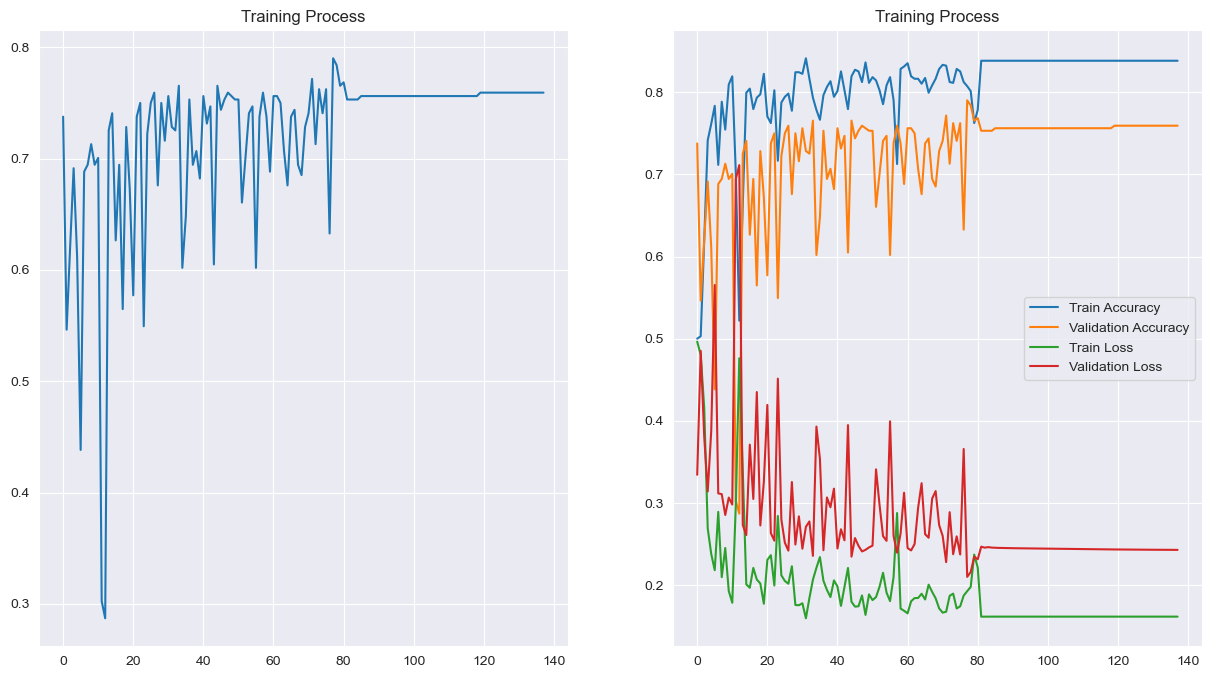

<Figure size 640x480 with 0 Axes>

In [20]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')

axes[1].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[1].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].legend()

plt.show()
plt.savefig('train.png')

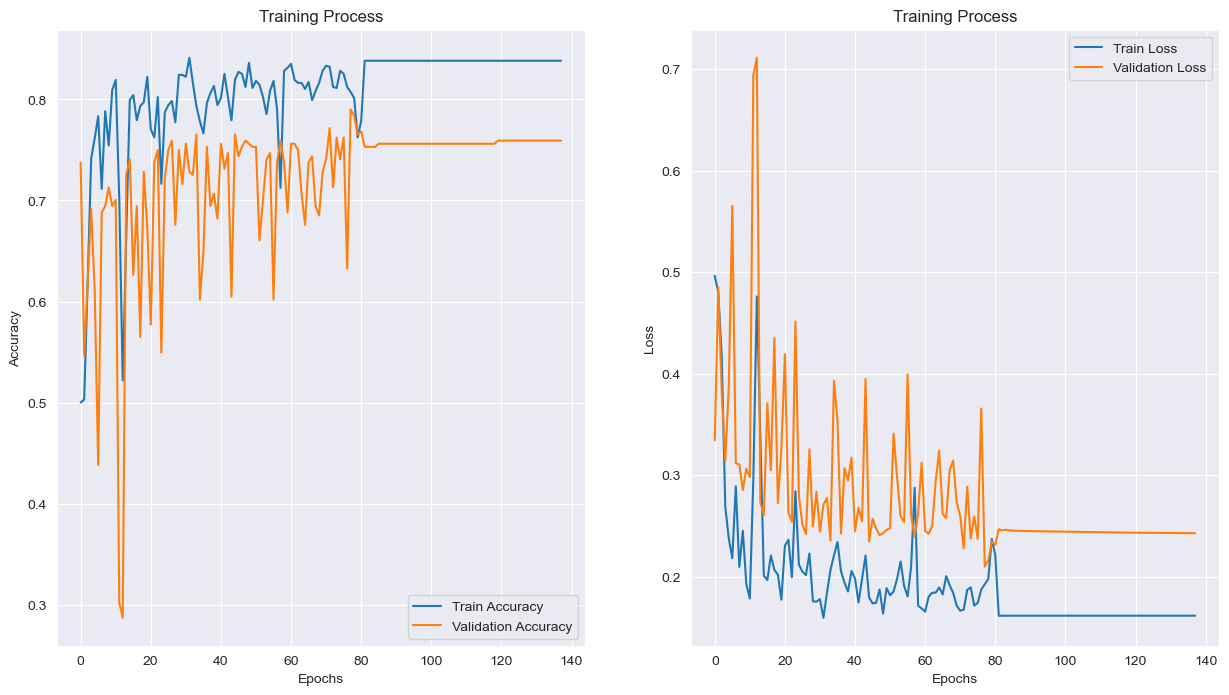

<Figure size 640x480 with 0 Axes>

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
history = model.history.history

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Biểu đồ accuracy của tập kiểm tra và tập validation
axes[0].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Biểu đồ loss của tập kiểm tra và tập validation
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Hiển thị biểu đồ
plt.show()

# Lưu biểu đồ vào file
plt.savefig('train.png')


In [22]:
predictions = model.predict(dict_data[data_order][2])
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_list[data_order], predictions)
accuracy

11/11 [==============================] - 0s 18ms/step


0.7901234567901234

In [23]:
model.save('vgg16_fraud1.h5')

In [24]:
x_test =dict_data[data_order][2]
y_test=y_list[data_order]

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.7901234567901234
Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.64      0.61        85
           0       0.87      0.85      0.86       239

    accuracy                           0.79       324
   macro avg       0.73      0.74      0.73       324
weighted avg       0.80      0.79      0.79       324



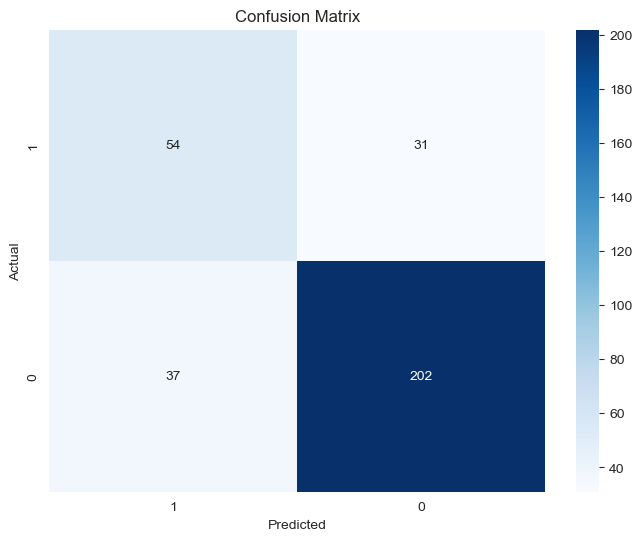

In [26]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

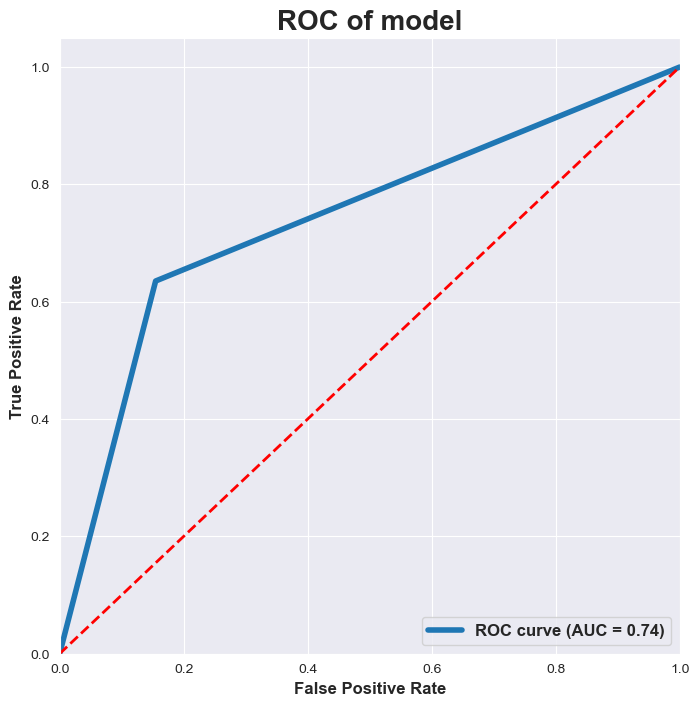

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, predictions,ax,name='model'):    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plot_roc_curve(y_test,predictions,axes)
# predictions

In [28]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [29]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = predictions
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: Y
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: Y
----------------------------
True: Y
Predicted: Y
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: Y
----------------------------
True: Y
Predicted: Y
----------------------------
True: Y
Predicted: N
----------------------------


In [30]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 256 chiếm khoảng 79.01234567901234% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 54 chiếm khoảng 63.52941176470588% so với thực tế
